### Cab-Driver Agent

In [1]:
#Google Colab specific
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/My Drive/Colab Notebooks/DriverLearning/RL Project(Cab-Driver)-Code Structure"

!ls "/content/drive/My Drive/Colab Notebooks/DriverLearning/RL Project(Cab-Driver)-Code Structure"


import os
os.environ['PYTHONPATH'] ="/content/drive/My Drive/Colab Notebooks/DriverLearning/RL Project(Cab-Driver)-Code Structure"

!echo $PYTHONPATH

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/DriverLearning/RL Project(Cab-Driver)-Code Structure/")

DQN_Agent_Arch1.ipynb  Env.py	      model_output  __pycache__   TM.npy
DQN_Agent_Arch2.ipynb  IM_env_5_2.py  OrigEnv.py    Rahul_Env.py
/content/drive/My Drive/Colab Notebooks/DriverLearning/RL Project(Cab-Driver)-Code Structure


In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [0]:
# Loading the time matrix provided
project_root = "/content/drive/My Drive/Colab Notebooks/DriverLearning/RL Project(Cab-Driver)-Code Structure/"
model_weight_folder  = project_root + "model_output/"
data_file = project_root + "TM.npy"
Time_matrix = np.load(data_file)

#### Tracking the state-action pairs for checking convergence


In [0]:
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

rewards_tracked = {(15,0):[],(25,1):[], (20,2): [], (30,3):[], (35,4):[], (10,5):[],(50,6):[]}


print(len(Q_dict))
print(len(rewards_tracked))
print(len(States_track))


In [0]:
with open('Policy.pkl', 'rb') as handle:
    Q_dict = pickle.load(handle)
    
with open('Rewards.pkl', 'rb') as handle:
    rewards_tracked = pickle.load(handle)    

with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)    
    
print(len(Q_dict))
print(len(rewards_tracked))
print(len(States_track))

In [0]:
#Defining a function which will add new Q-values to the Q-dictionary

def add_to_dict(state,valid_act):
    
    if state not in Q_dict.keys():
        Q_dict[state] = {}
        for action in valid_act:
            Q_dict[state][action] = 0.0

In [0]:
#This function will initialise the 7 Q-values which need to be tracked for checking convergence

#iters = []                            #the x-axis of convergence graphs

def initialise_tracking_states():
    sample_q_values = [((15,0),12),((25,1),25),((20,2),10),((30,3),30),((35,4),15),((10,5),18),((50,6),10)]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode   
        
        
        

In [0]:
#This function will append latest Q-values of the 4 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])            

In [0]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size, discount_factor=0.95, learning_rate=0.01,
                       epsilon=1, epsilon_decay=0.99, epsilon_min=0.01):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate       
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        # the input is a vector representing a state (of size 4 in case of cartpole) 
        input_shape = self.state_size

        model = Sequential()

        # hidden layers
        #model.add(Dense(32, input_shape==(self.state_size,), activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, input_dim=36, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
     
       


    def get_action(self, state):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
      
      print("current state {0}".format(state))
      if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return env.get_random_action(state)
            
      else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            
            print("Using q value method")
            state = self.envObj.state_encod_arch1(state)
            state = state.reshape(1, 36)
            q_value = self.model.predict(state)
            print("qvalue {0}".format(q_value))
            return np.argmax(q_value[0])    
        
        
        
        


    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
      self.memory.append((state, action, reward, next_state))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self, envObj):
        self.envObj = envObj
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            #update_output = np.zeros((self.batch_size, self.state_size), dtype=object)
            update_output = np.zeros((self.batch_size, 36))
            update_input = np.zeros((self.batch_size, 36))
            #update_input = np.zeros((self.batch_size, self.state_size), dtype=object)
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                
                state_encod = envObj.state_encod_arch1(state)
                
                #state_encod = state_encod.reshape(1, self.state_size)
                
                next_state_encod = envObj.state_encod_arch1(next_state)
                
                
                ##### new code
                update_input[i] = state_encod
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state_encod
                
                #done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            print(np.size(target)) 
            print(np.size(target, 0))
            print(np.size(target, 1))
            #print(target)

            # target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
              #if done[i]:
              #  target[i][actions[i]] = rewards[i]
              # non-terminal state  
              #else: 
              
              #print("value of i: %s"%i)
              #print("actions {0}".format(actions[i]))
             
              target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
                
                # Write your code from here
                # 1. Predict the target from earlier model
                
                
                # 2. Get the target for the Q-network
                
                
                #3. Update your 'update_output' and 'update_input' batch

                
                
        # 4. Fit your model and track the loss values


    def save(self, name):
      self.model.save(name)

In [0]:
Episodes = 30
Episode_end_point = 30

### DQN block

In [8]:
# to store rewards in each episode
from Env import CabDriver
env = CabDriver()

rewards_per_episode, episodes = [], []
state = env.state
state_size = len(env.state)
action_size = env.action_size

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(action_size=action_size, state_size=state_size)

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    
    # Import the environment
    

    # get size of state and action from environment

    
    
    num_of_days = 0
    done = False
    score = 0

    
   

    # make dir to store model weights
    #if not os.path.exists("saved_model_weights"):
    #    os.mkdir("saved_model_weights")
    

    #Call the DQN agent
    
    
    while not done:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        
        # get action for the current state and take a step in the environment
        action = agent.get_action(state)
        print("Action at this state {0}".format(env.action_space[action]))
        next_state, reward = env.step(state, action, Time_matrix)

        num_of_days += 1
        if num_of_days == 30:
          done = True
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action, reward, next_state)

        # train after each step
        agent.train_model(env)

        # add reward to the total score of this episode
        score += reward
        state = next_state
        
        

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
    
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        model_weight_file = model_weight_folder + "model_weights.h5"
        agent.save(name=model_weight_file)
        

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

rewards_per_episode: [-10.0, -179.0, -64.0, 10.0, 107.0, -37.0, -78.0, 22.0, -30.0, 45.0, 39.0, 83.0, -109.0, 1.0, 179.0, 56.0, 17.0, -71.0, 42.0, -26.0, 193.0, 29.0, 184.0, 55.0, 167.0, -45.0, 220.0, 102.0, 4.0, 11.0]


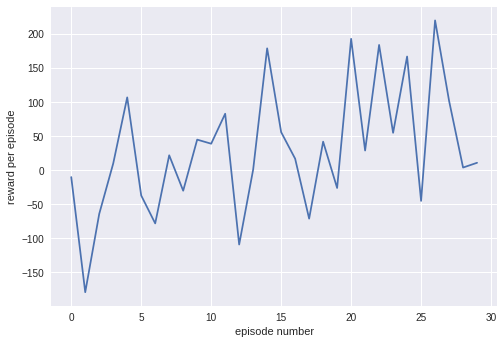

In [10]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

# save rewards_per_episode

rewards_file = model_weight_folder + "rewards_per_episode"
save_pickle(rewards_per_episode, rewards_file)


rewards_file = rewards_file + ".pkl"

# plot results
with open(rewards_file, 'rb') as f:
    rewards_per_episode = pickle.load(f)

print("rewards_per_episode: %s"%rewards_per_episode) 
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

plt.show()

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [0]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

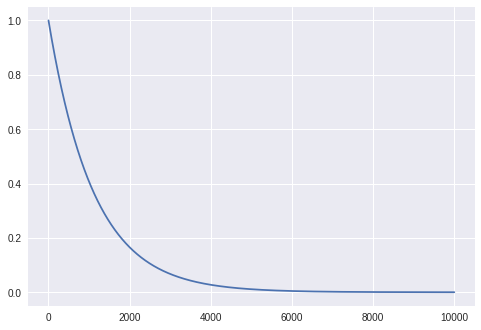

In [12]:
plt.plot(time, epsilon)
plt.show()